This notebook uses Julia 1.7.2 and is self-contained (does not rely on other notebooks).

In [76]:
import Pkg
Pkg.add("GraphRecipes")

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
   Installed Ratios ─────────── v0.4.3
   Installed NaNMath ────────── v0.3.7
   Installed NetworkLayout ──── v0.4.4
   Installed OffsetArrays ───── v1.10.8
   Installed GraphRecipes ───── v0.5.9
   Installed GeometryTypes ──── v0.8.5
   Installed ArnoldiMethod ──── v0.2.0
   Installed Graphs ─────────── v1.6.0
   Installed Inflate ────────── v0.1.2
   Installed SimpleTraits ───── v0.9.4
   Installed WoodburyMatrices ─ v0.5.5
   Installed AxisAlgorithms ─── v1.0.1
   Installed AbstractTrees ──── v0.3.4
   Installed Interpolations ─── v0.13.6
    Updating `~/.julia/environments/v1.7/Project.toml`
  [bd48cda9] + GraphRecipes v0.5.9
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [1520ce14] + AbstractTrees v0.3.4
  [ec485272] + ArnoldiMethod v0.2.0
  [13072b0f] + AxisAlgorithms v1.0.1
  [4d00f742] + GeometryTypes v0.8.5
  

In [78]:
using CSV, DataFrames, Shapefile, JuMP, Gurobi, Plots, GraphRecipes

In [2]:
const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-04


Gurobi.Env(Ptr{Nothing} @0x0000000159f82400, false, 0)

In [230]:
# Display all columns by default
ENV["COLUMNS"] = 1000

1000

Average ivermectin/person: 9.27

In [4]:
drc_data = CSV.read("data-CD-Oncho-iu.csv", DataFrame)
drc_data = filter(row -> row."Year" == 2019, drc_data)
drc_data[!, :"ivermectin_amt"] = drc_data."PopReq" .* 9.27

drc_data

,CONTINENT,REGION,WHO_REGION,ADMIN0,ADMIN0ID,ADMIN0_FIP,ADMIN0ISO2,ADMIN0ISO3,ADMIN1,ADMIN1ID,ADMIN2,ADMIN2ID,Alt_ADMIN2,ADMIN3,ADMIN3ID,IUs_ADM,IUs_NAME,IU_ID,IU_CODE,Year,PopTot,PopPreSAC,PopSAC,PopAdult,Endemicity,PopReq,PopTrg,PopTreat,Cov,Cum_MDA,MDA,EffMDA,MDA_n,EffMDA_n,EpiCov,EpiMDA,EpiEffMDA,EpiMDA_n,EpiEffMDA_n,MDA_scheme,Endemicity_ID,ivermectin_amt
,String7,String15,String7,String,Int64,String3,String3,String3,String15,Int64,String15,Int64,String7,String31,Int64,String7,String31,Int64,String15,Int64,Int64,Int64,Int64,Int64,String,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,String15,Int64,Float64
1,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Kwilu,24753,Bagata,0,null,Bagata,13816,ADM3,Bagata,13816,COD2475313816,2019,203103,34528,71086,93427,Unknown (under LF MDA),0,0,0,0.0,4,0,0,1,1,0.0,0,0,1,1,Not delivered,5,0.0
2,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Kwilu,24753,Bandundu,0,null,Bandundu,13818,ADM3,Bandundu,13818,COD2475313818,2019,189523,32219,66333,87181,Unknown (under LF MDA),0,0,0,0.0,4,0,0,1,1,0.0,0,0,1,1,Not delivered,5,0.0
3,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Kwango,24752,Kenge,0,null,Boko,13819,ADM3,Boko,13819,COD2475213819,2019,292409,49710,102343,134508,Endemic (under MDA),292409,236851,236868,100.01,6,1,1,4,4,81.01,1,1,4,3,IVM,2,2.71063e6
4,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Mai-Ndombe,24754,Kutu,0,null,Bokoro,13820,ADM3,Bokoro,13820,COD2475413820,2019,259679,44145,90888,119452,Unknown (consider Oncho Elimination Mapping),0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,Not delivered,4,0.0
5,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Mai-Ndombe,24754,Bolobo,0,null,Bolobo,13821,ADM3,Bolobo,13821,COD2475413821,2019,149070,25342,52175,68572,Unknown (consider Oncho Elimination Mapping),0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,Not delivered,4,0.0
6,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Mai-Ndombe,24754,Oshwe,0,null,Bosobe,13822,ADM3,Bosobe,13822,COD2475413822,2019,133039,22617,46564,61198,Unknown (consider Oncho Elimination Mapping),0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,Not delivered,4,0.0
7,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Kwilu,24753,Bulungu,0,null,Bulungu,13823,ADM3,Bulungu,13823,COD2475313823,2019,315311,53603,110359,145043,Unknown (under LF MDA),0,0,0,0.0,4,0,0,1,1,0.0,0,0,1,1,Not delivered,5,0.0
8,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Kwilu,24753,Bulungu,0,null,Djuma,13824,ADM3,Djuma,13824,COD2475313824,2019,248915,42316,87120,114501,Unknown (under LF MDA),0,0,0,0.0,4,0,0,1,1,0.0,0,0,1,1,Not delivered,5,0.0
9,Africa,Middle Africa,AFRO,Democratic Republic of the Congo,14,CG,CD,COD,Kwango,24752,Feshi,0,null,Feshi,13825,ADM3,Feshi,13825,COD2475213825,2019,160401,27268,56140,73784,Unknown (under LF MDA),0,0,0,0.0,2,0,0,1,1,0.0,0,0,1,1,Not delivered,5,0.0


In [5]:
drc_loc_T = Shapefile.Table("cod_admbnda_rgc_itos_20190911_shp/cod_admbndp_admALL_rgc_itos_20190911.shp")
drc_loc = DataFrame(drc_loc_T)

,geometry,ADM0_FR,ADM0_PCODE,ADM1_FR,ADM1_PCODE,ADM2_FR,ADM2_PCODE,ADM2_REF,ADM2ALT1FR,ADM2ALT2FR,POINT_X,POINT_Y
,Point,String,String,String,String,String,String,String?,Missing,Missing,Float64,Float64
1,"Point(30.2382, 3.85842)",République démocratique du Congo (la),CD,Haut-Uele,CD53,Aba,CD5306,missing,missing,missing,30.2382,3.85842
2,"Point(23.7546, 2.98007)",République démocratique du Congo (la),CD,Bas-Uele,CD52,Aketi,CD5204,missing,missing,missing,23.7546,2.98007
3,"Point(26.0726, 4.47187)",République démocratique du Congo (la),CD,Bas-Uele,CD52,Ango,CD5207,missing,missing,missing,26.0726,4.47187
4,"Point(30.707, 3.13686)",République démocratique du Congo (la),CD,Ituri,CD54,Ariwara,CD5410,missing,missing,missing,30.707,3.13686
5,"Point(30.5333, 3.06645)",République démocratique du Congo (la),CD,Ituri,CD54,Aru,CD5409,missing,missing,missing,30.5333,3.06645
6,"Point(26.9969, 0.735506)",République démocratique du Congo (la),CD,Tshopo,CD51,Bafwasende,CD5111,missing,missing,missing,26.9969,0.735506
7,"Point(17.7111, -3.90487)",République démocratique du Congo (la),CD,Kwilu,CD32,Bagata,CD3202,missing,missing,missing,17.7111,-3.90487
8,"Point(25.9729, 3.09299)",République démocratique du Congo (la),CD,Bas-Uele,CD52,Bambesa,CD5209,missing,missing,missing,25.9729,3.09299
9,"Point(25.4582, 1.58373)",République démocratique du Congo (la),CD,Tshopo,CD51,Banalia,CD5110,missing,missing,missing,25.4582,1.58373


In [6]:
drc_loc_only = drc_loc[!, ["ADM2_FR", "POINT_X", "POINT_Y"]]

,ADM2_FR,POINT_X,POINT_Y
,String,Float64,Float64
1,Aba,30.2382,3.85842
2,Aketi,23.7546,2.98007
3,Ango,26.0726,4.47187
4,Ariwara,30.707,3.13686
5,Aru,30.5333,3.06645
6,Bafwasende,26.9969,0.735506
7,Bagata,17.7111,-3.90487
8,Bambesa,25.9729,3.09299
9,Banalia,25.4582,1.58373


In [19]:
# Fix name inconsistencies
drc_data[drc_data.ADMIN2 .== "Katako Kombe", :ADMIN2] .= "Katako-Kombe"
drc_data[drc_data.ADMIN2 .== "Oicha", :ADMIN2] .= "Oïcha"
;

In [217]:
# Combine locations with same ADMIN2 (district)
drc_data_collapsed = combine(groupby(drc_data, :ADMIN2), :ivermectin_amt => sum)

,ADMIN2,ivermectin_amt_sum
,String15,Float64
1,Bagata,0.0
2,Bandundu,0.0
3,Kenge,7.42022e6
4,Kutu,0.0
5,Bolobo,0.0
6,Oshwe,0.0
7,Bulungu,2.93974e6
8,Feshi,1.01745e6
9,Gungu,0.0


In [237]:
# Data join!
drc_data_combined = leftjoin(drc_data_collapsed, drc_loc_only, on = "ADMIN2" => "ADM2_FR")

,ADMIN2,ivermectin_amt_sum,POINT_X,POINT_Y
,String15,Float64,Float64?,Float64?
1,Aketi,2.15457e6,23.7546,2.98007
2,Ango,1.69368e6,26.0726,4.47187
3,Aru,7.75812e6,30.5333,3.06645
4,Bafwasende,2.17604e6,26.9969,0.735506
5,Bagata,0.0,17.7111,-3.90487
6,Bambesa,1.32259e6,25.9729,3.09299
7,Banalia,2.77995e6,25.4582,1.58373
8,Bandundu,0.0,17.4452,-3.31634
9,Basankusu,3.80677e6,20.0009,1.0873


In [219]:
# Look for missing data
filter(row -> ismissing(row."POINT_X"), drc_data_combined)

,ADMIN2,ivermectin_amt_sum,POINT_X,POINT_Y
,String15,Float64,Float64?,Float64?


In [10]:
# Used this to find some naming inconsistencies between the two dataframes
# filter(name -> startswith(name, "O"), drc_loc_only."ADM2_FR")

In [238]:
filter!(row -> row.ivermectin_amt_sum > 0, drc_data_combined)
size(drc_data_combined)

(128, 4)

data processing above

---

model below

In [244]:
drc_data_combined = drc_data_combined[1:20, :];

In [245]:
# Back to regular column width
ENV["COLUMNS"] = 80

80

In [246]:
# May consider changing to great circle distance
function distance(x1, y1, x2, y2)
    sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

distance (generic function with 1 method)

In [275]:
num_counties = length(drc_data_combined."ADMIN2")
num_vehicles = 6
max_capacity = 2e7 # some viable constraint on the max number of mg that one vehicle can carry
batch_amt = 1e8

drc_loc_x = drc_data_combined[!, "POINT_X"]
drc_loc_y = drc_data_combined[!, "POINT_Y"]
drc_dists = [distance(drc_loc_x[i], drc_loc_y[i], drc_loc_x[j], drc_loc_y[j])
    for i=1:num_counties, j=1:num_counties]

drc_dosage = drc_data_combined[!, "ivermectin_amt_sum"]


## MODEL START

m = Model(() -> Gurobi.Optimizer(GRB_ENV))

# variables

# path from i->j in service
@variable(m, s_ij[i=1:num_counties, j=1:num_counties], Bin)

# vehicle n services location i
@variable(m, v_in[i=1:num_counties, n=1:num_vehicles], Bin)

# location i is our chosen central hub
@variable(m, c_i[i=1:num_counties], Bin)

# vehicle n ends up at location i
@variable(m, e_in[i=1:num_counties, n=1:num_vehicles], Bin)

# amount of ivermectin remaining before vehicle n delivers to location i
@variable(m, d_in[i=1:num_counties, n=1:num_vehicles] >= 0)


# constraints

# vehicle doesn't explode
@constraint(m, [n=1:num_vehicles], sum(d_in[:, n] .* c_i) <= max_capacity)

# self-loops are not allowed
@constraint(m, [i=1:num_counties], s_ij[i, i] == 0)

# exactly one central hub
@constraint(m, sum(c_i) == 1)

# exactly one ending location per vehicle
@constraint(m, [n=1:num_vehicles], sum(e_in[:, n]) == 1)

# nodes in service graph have outdegree == indegree, except for central hub and
# ending locations
@constraint(m, [i=1:num_counties],
    sum(s_ij[i, :]) - sum(s_ij[:, i]) == c_i[i] * num_vehicles - sum(e_in[i, :]))

# additionally force indegree <= 1, except for central hub force indegree <= 0
@constraint(m, [i=1:num_counties], sum(s_ij[:, i]) <= 1 - c_i[i])

# if vehicle n serviced location i, then there must be some incoming edge from a location
# also serviced by vehicle n UNLESS i is central hub
@constraint(m, [i=1:num_counties, n=1:num_vehicles],
    sum(s_ij[:, i] .* v_in[:, n]) >= v_in[i, n] * (1 - c_i[i]))

# # no two vehicles visit the same location UNLESS it's the central hub
@constraint(m, [i=1:num_counties, n=1:num_vehicles, n2=1:num_vehicles; n2 != n],
    v_in[i, n] + v_in[i, n2] <= 1 + c_i[i])

# ivermectin is only delivered to location i if vehicle n services it
@constraint(m, [i=1:num_counties, n=1:num_vehicles], d_in[i, n] <= v_in[i, n] * max_capacity)

# total ivermectin delivered to any location is at most the amount required
@constraint(m, [i=1:num_counties],
    0 <= sum(d_in[i, :]) - sum(d_in .* s_ij[i, :]) <= drc_dosage[i])

# total ivermectin delivered to END location is at most the amount required
@constraint(m, [i=1:num_counties],
    sum(d_in[i, :] .* e_in[i, :]) <= drc_dosage[i])

# all ivermectin should be delivered
@constraint(m, sum(d_in .* c_i) == batch_amt)


# objective

# minimize total travel distance
@objective(m, Min, sum(s_ij .* drc_dists))
;

In [ ]:
optimize!(m)

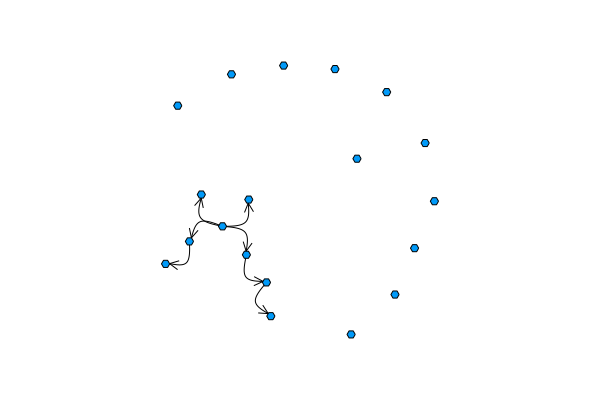

In [274]:
graphplot(value.(s_ij))